In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Define the Neural Network class (X->ReLU->Softmax)

In [2]:
class NeuralNetwork(object):
    def __init__(self, input_size = 784, classes = 10, hidden_size = 20):
        self.input_size = input_size
        self.output_size = classes
        self.hidden_size = hidden_size

        self.w1 = np.random.randn(input_size, hidden_size) / 28 #HE initialization
        self.w2 = np.random.randn(hidden_size, classes) / 10 #HE initialization
        self.b1 = np.zeros([1, hidden_size])
        self.b2 = np.zeros([1, classes])

        self.a2 = None
        self.z2 = None
        self.a1 = None
        self.z1 = None

        self.lmbda_reg = 0.001

    def ReLU(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0, z)

    def softmax(self, z_c: np.ndarray) -> np.ndarray:
        z = np.copy(z_c)
        z -= np.max(z, axis=1, keepdims=True) # shift values
        e_z = np.exp(z)
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    def ReLU_derivative(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0, 1, 0)

    def forward(self, x_set: np.ndarray) -> np.ndarray:
        self.z1 = self.b1 + x_set @ self.w1
        self.a1 = self.ReLU(self.z1)
        self.z2 = self.b2 + self.a1 @ self.w2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def l2_regularization(self):
        return self.lmbda_reg / 2 * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))

    def cost(self, y_set: np.ndarray, output: np.ndarray) -> float:
        epsilon = 1e-10
        output = np.clip(output, epsilon, 1 - epsilon)
        return -np.sum(y_set * np.log(output)) / y_set.shape[0] + self.l2_regularization()

    def calculate_accuracy(self, y_set: np.ndarray, output: np.ndarray):
        pred_classes = np.argmax(output, axis=1)
        actual_classes = np.argmax(y_set, axis=1)

        return 100.0 * np.sum(pred_classes == actual_classes) / actual_classes.shape[0]

    def backward(self, x_set: np.ndarray, y_set: np.ndarray, output: np.ndarray, lr=0.05):
        m = x_set.shape[0]
        delta_output = output - y_set
        delta_hidden = delta_output @ self.w2.T * self.ReLU_derivative(self.z1)

        # Compute gradients for the weights and biases
        grad_w2 = self.a1.T @ delta_output / m + (2 * self.lmbda_reg * self.w2)
        grad_b2 = np.mean(delta_output, axis=0, keepdims=True)
        grad_w1 = x_set.T @ delta_hidden / m + (2 * self.lmbda_reg * self.w1)
        grad_b1 = np.mean(delta_hidden, axis=0, keepdims=True)

        # Update weights and biases using gradient descent
        self.w2 -= lr * grad_w2
        self.b2 -= lr * grad_b2
        self.w1 -= lr * grad_w1
        self.b1 -= lr * grad_b1

    def print_confusion_matrix(self, x_set: np.ndarray, y_set: np.ndarray):
        import tableprint as tab
        output = self.forward(x_set)
        output_classes = np.argmax(output, axis=1)
        actual_classes = np.argmax(y_set, axis=1)
        conf_matrix = np.zeros((self.output_size, self.output_size), dtype=int)

        for i in range(len(actual_classes)):
            conf_matrix[actual_classes[i], output_classes[i]] += 1

        headers = ['CnfMat'] + [f'pr: {x}' for x in range(self.output_size)] + ['all a']
        table = []
        for i in range(self.output_size):
            row = [f'act: {i}'] + list(conf_matrix[i, :]) + [np.sum(conf_matrix[i, :])]
            table.append(row)
        table.append(['all p'] + list(np.sum(conf_matrix, axis=0)) + [np.sum(conf_matrix)])

        tab.table(table, headers, width=6)

    def plot(self, values, accurracies, values_validation, accurracies_validation):
        fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
        ax[0].plot([x * 10 for x in range(len(values))], values, color="red")
        ax[0].plot([x * 10 for x in range(len(values_validation))], values_validation, color="yellow")
        ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
        ax[0].grid()
        ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, color="magenta")
        ax[1].plot([x * 10 for x in range(len(accurracies_validation))], accurracies_validation, color="green")
        ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
        ax[1].grid()
        plt.show()

    def train(self, x_set: np.ndarray, y_set: np.ndarray, x_set_validation: np.ndarray, y_set_validation: np.ndarray, epochs = 500):
        cost_values = []
        cost_values_validation = []
        accuracies = []
        accuracies_validation = []

        rate = 0.8995 #bigger lr, slope is very big
        for epoch in range(epochs):
            output = self.forward(x_set)
            self.backward(x_set, y_set, output, rate)
            accuracies.append(self.calculate_accuracy(y_set, output))
            cost_values.append(self.cost(y_set, output))

            output_validation = self.forward(x_set_validation)
            accuracies_validation.append(self.calculate_accuracy(y_set_validation, output_validation))
            cost_values_validation.append(self.cost(y_set_validation, output_validation))
            if epoch % 10 == 0:
                print('Epoch ', str(epoch), ' Accuracy for the training is:', accuracies[-1])
                print('Cost: ', cost_values[-1])
                rate *= 0.9355 #adaptive lr
        self.plot(cost_values, accuracies, cost_values_validation, accuracies_validation)


In [3]:
def show_samples(x_set: np.ndarray, y_set: np.ndarray):
    size = x_set.shape[0]

    fig, ax = plt.subplots(size // 5, 5, figsize=(20, 10))
    for k in range(size):
        row, col = k // 5, k % 5
        pixels = np.array(x_set[k], dtype='uint8')

        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)

        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()

Testing the Neural Network

In [4]:
NN = NeuralNetwork(hidden_size=38)

Load mnist dataset from a pkl file

In [5]:
with open('mnist.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

    x_train_pkl, y_train_pkl = data[0][0], data[0][1]
    x_validation_pkl, y_validation_pkl = data[1][0], data[1][1]
    x_test_pkl, y_test_pkl = data[2][0], data[2][1]

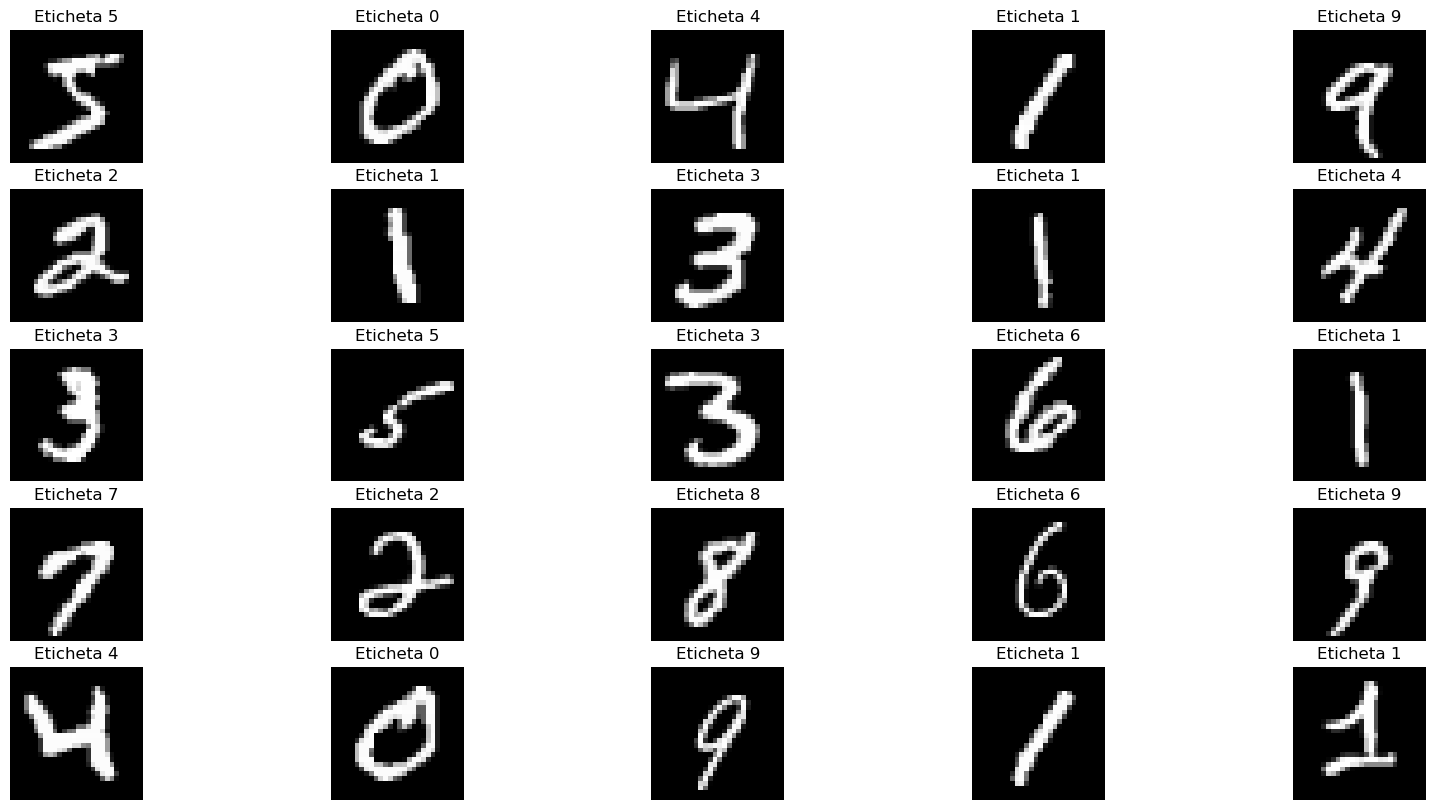

In [6]:
show_samples(255 * x_train_pkl[:25, :], y_train_pkl[:25])

Defina one hot encoding function

In [7]:
def one_hot(val, classes = 10) -> np.ndarray:
    hot_array = np.array([1 if i == val else 0 for i in range(classes)]).reshape([1, classes])
    return hot_array

Convert Y dataset to one hot

In [8]:
y_train_pkl_hot = np.concatenate([one_hot(i) for i in y_train_pkl])
y_validation_pkl_hot = np.concatenate([one_hot(i) for i in y_validation_pkl])
y_test_pkl_hot = np.concatenate([one_hot(i) for i in y_test_pkl])

Train the neural network

Epoch  0  Accuracy for the training is: 9.558
Cost:  2.318630997850266
Epoch  10  Accuracy for the training is: 49.96
Cost:  1.4199111894664047
Epoch  20  Accuracy for the training is: 77.214
Cost:  0.7651924334592857
Epoch  30  Accuracy for the training is: 74.548
Cost:  0.7524039711658719
Epoch  40  Accuracy for the training is: 87.27
Cost:  0.46298895118600686
Epoch  50  Accuracy for the training is: 87.394
Cost:  0.4534850001615964
Epoch  60  Accuracy for the training is: 89.786
Cost:  0.3995332150701202
Epoch  70  Accuracy for the training is: 90.372
Cost:  0.38071195952315096
Epoch  80  Accuracy for the training is: 90.862
Cost:  0.36597360909955223
Epoch  90  Accuracy for the training is: 91.084
Cost:  0.35666287897440074
Epoch  100  Accuracy for the training is: 91.318
Cost:  0.3492935478185548
Epoch  110  Accuracy for the training is: 91.522
Cost:  0.3431020404691779
Epoch  120  Accuracy for the training is: 91.662
Cost:  0.3378113531113776
Epoch  130  Accuracy for the trainin

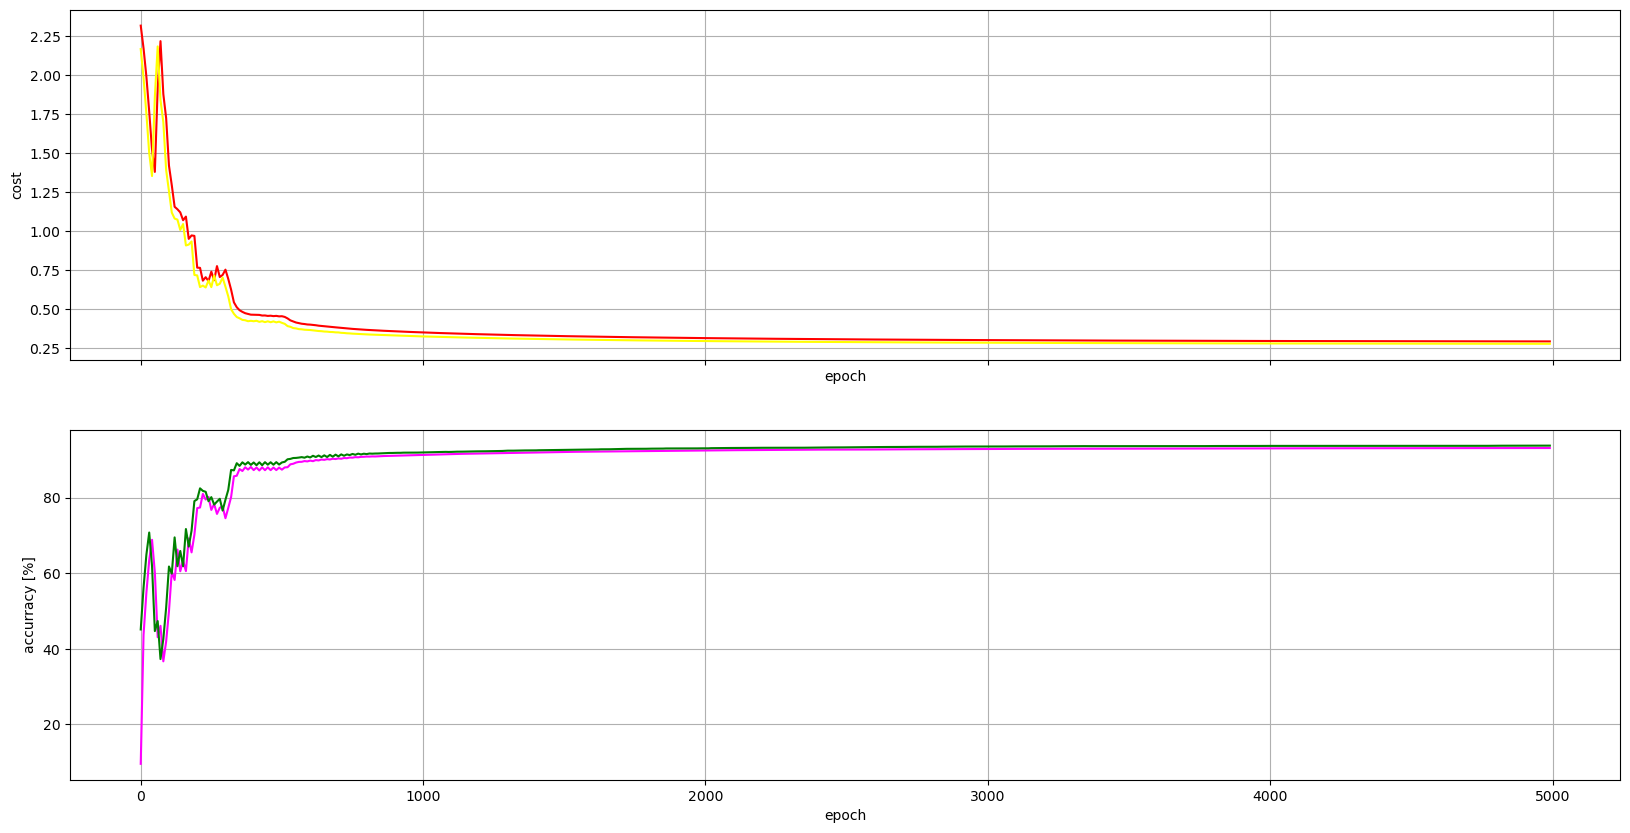

In [9]:
NN.train(x_train_pkl, y_train_pkl_hot, x_validation_pkl, y_validation_pkl_hot)

In [10]:
print('Accuracy for the test set:', NN.calculate_accuracy(y_test_pkl_hot, NN.forward(x_test_pkl)))

Accuracy for the test set: 93.35


In [11]:
NN.print_confusion_matrix(x_test_pkl, y_test_pkl_hot)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    959 │      0 │      3 │      1 │      0 │      3 │      9 │      3 │      2 │      0 │    980 │
│ act: 1 │      0 │   1112 │      2 │      2 │      0 │      2 │      4 │      1 │     12 │      0 │   1135 │
│ act: 2 │      9 │      5 │    939 │     11 │     15 │      1 │      9 │     14 │     26 │      3 │   1032 │
│ act: 3 │      1 │      1 │     15 │    942 │      0 │     18 │      2 │     12 │     13 │      6 │   1010 │
│ act: 4 │      1 │      4 │      5 │      0 │    923 │      0 │      8 │      2 │      5 │     34 │    982 │
│ act: 5 │      9 │      3 │      4 │     33 │      7 │    797 │     13 │      2 │     16 │      8 │    892 │
│ act: 6 │

Overall results:
with Batch GD(lmbda=0.01, rate=0.8295(*0.9455 / epoch % 10), epochs=500, hidden=36) + l2 => 92% accuracy
with Batch GD(lmbda=0.01, rate=0.8995(*0.9355 / epoch % 10), epochs=500, hidden=38) + l2 => 93% accuracy
with Batch GD(rate=0.9005(*0.9505 / epoch % 10), epochs=1000, hidden=36) => 96% accuracy (maybe overwriting but not actually)

